# ANEXO

## Importo librerías

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import math
import sys

import sympy as sp
from sympy.solvers import solve

import scipy
from scipy.linalg import solve as solve_matrix
from scipy.integrate import quad

import matplotlib.pyplot as plt

# Preliminar

** Leo datos del csv **

In [2]:
info = pd.read_csv("DATOS_CHILE.csv")

** Calculo la cantidad de días entre los casos **

In [3]:
#Se observa que el día cero es el 2020-03-04 ya que es el primer día en el que hay una infección

dia_0 = dt.datetime(year=2020,month=3,day=4)

In [4]:
# Le resto el día cero a la fecha actual

info["day"] = pd.to_datetime(info['date']) - dia_0
info["day"] = pd.to_numeric(info['day'].dt.days, downcast='integer')

In [5]:
info.head()

,date,total_cases,new_cases,population,day
0,2020-03-04,1,1,19116209,0
1,2020-03-05,3,2,19116209,1
2,2020-03-06,4,1,19116209,2
3,2020-03-07,5,1,19116209,3
4,2020-03-09,10,5,19116209,5


** Verifico que total_cases coincide con new_cases acumulado **

In [6]:
# Creo una nueva tabla para comparar

info_comprobación = info[["total_cases", 'new_cases']].copy()

In [7]:
# Calculo new_cases acumulado

for i in range(1, len(info_comprobación)):
    info_comprobación.loc[i, 'new_cases'] = info_comprobación.loc[i-1, 'new_cases']  + info_comprobación.loc[i, 'new_cases']

In [8]:
# Comparo total_cases con new_cases acumulado y seobserva que los valores coinciden

(info_comprobación["total_cases"] == info_comprobación["total_cases"]).all()

True

** Observo que population es un valor constante **

In [9]:
info["population"].value_counts()

19116209    120
Name: population, dtype: int64

In [10]:
total_cases = info["total_cases"]

## METODO A

### A1) Discretización RK-2

** Relleno df de ceros y valores iniciales para calcular la discretización **

In [11]:
def inicializacion_df_SIR(m,N):
    
    info_A = pd.DataFrame()
    info_A ["day"] = np.arange(0,m,1)
    
    info_A['un'] = np.float128(0.0)
    info_A['vn'] = np.float128(0.0)
    info_A['wn'] =np.float128(0.0)

    # Primer infectado:inicializacion_df_RK
    info_A.loc[0, 'vn'] = 1.0

    # population inicial
    info_A.loc[0, 'un'] = N-1.0
    
    return info_A

** Creo funciones que calculan la discretización **

In [12]:
# Calculo los n+1/2

def un_intermedio(un,vn,beta,alfa,n,h):
    return un + (h/2)*(-(beta*un*vn)/n)

def vn_intermedio(un,vn,beta,alfa,n,h):
    return vn + (h/2) * ((beta/n)*un*vn-alfa*vn)

def wn_intermedio(wn,vn,beta,alfa,n,h):
    return wn + (h/2) * (alfa*vn)

In [13]:
# Calculo los n+1

def RK_un_sig(un,vn,beta,alfa,n,h):
    
    un_inter = un_intermedio(un,vn,beta,alfa,n,h)
    vn_inter = vn_intermedio(un,vn,beta,alfa,n,h)
    
    un_siguiente = un - (h*beta*un_inter*vn_inter)/n
    
    return un_siguiente

def RK_vn_sig(un,vn,beta,alfa,n,h):
    
    un_inter = un_intermedio(un,vn,beta,alfa,n,h)
    vn_inter = vn_intermedio(un,vn,beta,alfa,n,h)
    
    vn_siguiente = vn + h * ((beta*un_inter*vn_inter)/n - alfa*vn_inter)
    
    return vn_siguiente

def RK_wn_sig(un,vn,wn,beta,alfa,n,h):
    
    vn_inter = vn_intermedio(un,vn,beta,alfa,n,h)
    
    wn_siguiente = wn + h * alfa * vn_inter
    
    return wn_siguiente

** Aplico funciones a la tabla **

In [14]:
# Calculo new_cases acumulado

def discretizacion_RK_2(beta,alfa,n,h,m):
    
    info = inicializacion_df_SIR(m,n)

    for i in range(1, len(info)):
        un = info.loc[i-1, 'un']
        vn = info.loc[i-1, 'vn']
        wn = info.loc[i-1, 'wn']
        
        info.loc[i, 'un'] = RK_un_sig(un,vn,beta,alfa,n,h)
        info.loc[i, 'vn'] = RK_vn_sig(un,vn,beta,alfa,n,h)
        info.loc[i, 'wn'] = RK_wn_sig(un,vn,wn,beta,alfa,n,h)
    
    return info

### A2) Estabilidad teórica

In [15]:
# Creo las variables

a = sp.Symbol('γ')
b = sp.Symbol('β')
h = sp.Symbol('h')
N = sp.Symbol('N')

un = sp.Symbol('u^n')
vn = sp.Symbol('v^n')
wn = sp.Symbol('w^n')


dun = sp.Symbol('δu^n')
dvn = sp.Symbol('δv^n')
dwn = sp.Symbol('δw^n')

dun_sig = sp.Symbol('δu^n+1')
dvn_sig = sp.Symbol('δv^n+1')
dwn_sig = sp.Symbol('δw^n+1')

#### Obtengo las ecuaciones con RK-2

In [16]:
# Funciones auxiliares

def _un_medio(un,vn,h,N,b,a):
    return un - (h/2) * (b/N) * vn*un

def _vn_medio(un,vn,h,N,b,a):
    return vn + (h/2) *( (b/N) * vn*un - a*vn)

def _un_sig(un,vn,un_medio,vn_medio,h,N,b,a):
    return un - h * (b/N) * vn_medio* un_medio

def _vn_sig(un,vn,un_medio,vn_medio,h,N,b,a):
    return vn + h *( (b/N) * vn_medio*un_medio - a*vn_medio)

def _wn_sig(wn,vn,un_medio,vn_medio,h,N,b,a):
    return wn + h * a * vn_medio

##### prediccion

In [17]:
un_medio = _un_medio(un,vn,h,N,b,a)
vn_medio = _vn_medio(un,vn,h,N,b,a)

In [18]:
un_medio

u^n - h*u^n*v^n*β/(2*N)

In [19]:
vn_medio

h*(-v^n*γ + u^n*v^n*β/N)/2 + v^n

##### corrección

In [20]:
un_sig = _un_sig(un,vn,un_medio,vn_medio,h,N,b,a)
vn_sig = _vn_sig(un,vn,un_medio,vn_medio,h,N,b,a)
wn_sig = _wn_sig(wn,vn,un_medio,vn_medio,h,N,b,a)

In [21]:
un_sig

u^n - h*β*(u^n - h*u^n*v^n*β/(2*N))*(h*(-v^n*γ + u^n*v^n*β/N)/2 + v^n)/N

In [22]:
vn_sig

h*(-γ*(h*(-v^n*γ + u^n*v^n*β/N)/2 + v^n) + β*(u^n - h*u^n*v^n*β/(2*N))*(h*(-v^n*γ + u^n*v^n*β/N)/2 + v^n)/N) + v^n

In [23]:
wn_sig

h*γ*(h*(-v^n*γ + u^n*v^n*β/N)/2 + v^n) + w^n

#### Perturbación

In [24]:
perturbaciones ={
    un: un+dun,
    vn: vn+dvn,
    wn: wn+dwn,
}

In [25]:
un_sig_perturbado = un_sig.subs(perturbaciones)
vn_sig_perturbado = vn_sig.subs(perturbaciones)
wn_sig_perturbado = wn_sig.subs(perturbaciones)

In [26]:
un_sig_perturbado

u^n + δu^n - h*β*(u^n + δu^n - h*β*(u^n + δu^n)*(v^n + δv^n)/(2*N))*(h*(-γ*(v^n + δv^n) + β*(u^n + δu^n)*(v^n + δv^n)/N)/2 + v^n + δv^n)/N

In [27]:
vn_sig_perturbado

h*(-γ*(h*(-γ*(v^n + δv^n) + β*(u^n + δu^n)*(v^n + δv^n)/N)/2 + v^n + δv^n) + β*(u^n + δu^n - h*β*(u^n + δu^n)*(v^n + δv^n)/(2*N))*(h*(-γ*(v^n + δv^n) + β*(u^n + δu^n)*(v^n + δv^n)/N)/2 + v^n + δv^n)/N) + v^n + δv^n

In [28]:
wn_sig_perturbado

h*γ*(h*(-γ*(v^n + δv^n) + β*(u^n + δu^n)*(v^n + δv^n)/N)/2 + v^n + δv^n) + w^n + δw^n

#### Despreciación de potencias de deltas

In [29]:
dun_sig_nuevo = un_sig_perturbado- un_sig
dvn_sig_nuevo = vn_sig_perturbado- un_sig
dwn_sig_nuevo = wn_sig_perturbado- un_sig

In [30]:
despreciacion ={
    
    dun**2: 0,
    dvn**2: 0,
    dwn**2: 0,
    
    dun_sig**2: 0,
    dvn_sig**2: 0,
    dvn_sig**2: 0,
    
    dvn*dun: 0,
    dwn*dvn: 0,
    dun*dwn: 0,
    
    dvn_sig*dun_sig: 0,
    dwn_sig*dvn_sig: 0,
    dun_sig*dwn_sig: 0,
    
    dun*dun_sig:0,
    dun*dvn_sig:0,
    dun*dwn_sig:0,
    
    dvn*dun_sig:0,
    dvn*dvn_sig:0,
    dvn*dwn_sig:0,
    
    dwn*dun_sig:0,
    dwn*dvn_sig:0,
    dwn*dwn_sig:0,
    
    (un+dun)*(vn+dvn) : un*vn + (un*dvn) + (vn*dun),
    (un+2*dun)*(vn+2*dvn) : un*vn + (2*un*dvn) + (2*vn*dun)
}

In [31]:
dun_sig_aprox = dun_sig_nuevo.expand(basic=True).subs(despreciacion)
dvn_sig_aprox = dvn_sig_nuevo.expand(basic=True).subs(despreciacion)
dwn_sig_aprox = dwn_sig_nuevo.expand(basic=True).subs(despreciacion)

In [32]:
dun_sig_aprox

δu^n + h**2*u^n*β*γ*δv^n/(2*N) + h**2*v^n*β*γ*δu^n/(2*N) - h*u^n*β*δv^n/N - h*v^n*β*δu^n/N - h**3*u^n*v^n*β**2*γ*δv^n/(2*N**2) - h**3*v^n**2*β**2*γ*δu^n/(4*N**2) - h**2*u^n**2*β**2*δv^n/(2*N**2) - h**2*u^n*v^n*β**2*δu^n/N**2 + h**2*u^n*v^n*β**2*δv^n/N**2 + h**2*v^n**2*β**2*δu^n/(2*N**2) + h**3*u^n**2*v^n*β**3*δv^n/(2*N**3) + h**3*u^n*v^n**2*β**3*δu^n/(2*N**3)

In [33]:
dvn_sig_aprox

h**2*v^n*γ**2/2 + h**2*γ**2*δv^n/2 - h*v^n*γ - h*γ*δv^n - u^n + v^n + δv^n - 3*h**2*u^n*v^n*β*γ/(2*N) - h**2*u^n*β*γ*δv^n/N - h**2*v^n*β*γ*δu^n/N + 2*h*u^n*v^n*β/N + h*u^n*β*δv^n/N + h*v^n*β*δu^n/N + h**3*u^n*v^n**2*β**2*γ/(2*N**2) + h**3*u^n*v^n*β**2*γ*δv^n/(2*N**2) + h**3*v^n**2*β**2*γ*δu^n/(4*N**2) + h**2*u^n**2*v^n*β**2/N**2 + h**2*u^n**2*β**2*δv^n/(2*N**2) - h**2*u^n*v^n**2*β**2/N**2 + h**2*u^n*v^n*β**2*δu^n/N**2 - h**2*u^n*v^n*β**2*δv^n/N**2 - h**2*v^n**2*β**2*δu^n/(2*N**2) - h**3*u^n**2*v^n**2*β**3/(2*N**3) - h**3*u^n**2*v^n*β**3*δv^n/(2*N**3) - h**3*u^n*v^n**2*β**3*δu^n/(2*N**3)

In [34]:
dwn_sig_aprox

-h**2*v^n*γ**2/2 - h**2*γ**2*δv^n/2 + h*v^n*γ + h*γ*δv^n - u^n + w^n + δw^n + h**2*u^n*β*γ*δv^n/(2*N) + h**2*v^n*β*γ*δu^n/(2*N) + h*u^n*v^n*β/N + h**3*u^n*v^n**2*β**2*γ/(4*N**2) + h**2*u^n**2*v^n*β**2/(2*N**2) - h**2*u^n*v^n**2*β**2/(2*N**2) - h**3*u^n**2*v^n**2*β**3/(4*N**3)

#### Get matrix

In [35]:
A  = [[0,0,0],[0,0,0],[0,0,0]]

##### un coeficientes

In [36]:
A[0][0] = dun_sig_aprox.coeff(dun, 1)

In [37]:
A[0][1] = dun_sig_aprox.coeff(dvn, 1)

In [38]:
A[0][2] = dun_sig_aprox.coeff(dwn, 1)

##### wn coeficientes

In [39]:
A[2][0] = dwn_sig_aprox.coeff(dun, 1)

In [40]:
A[2][1] = dwn_sig_aprox.coeff(dvn, 1)

In [41]:
A[2][2] = dwn_sig_aprox.coeff(dwn, 1)

##### vn coeficientes

In [42]:
A[1][0] = dvn_sig_aprox.coeff(dun, 1)

In [43]:
A[1][1] = dvn_sig_aprox.coeff(dvn, 1)

In [44]:
A[1][2] = dvn_sig_aprox.coeff(dwn, 1)

#### Autovalores

In [45]:
matrix = sp.Matrix(A)

In [46]:
matrix

Matrix([
[1 + h**2*v^n*β*γ/(2*N) - h*v^n*β/N - h**3*v^n**2*β**2*γ/(4*N**2) - h**2*u^n*v^n*β**2/N**2 + h**2*v^n**2*β**2/(2*N**2) + h**3*u^n*v^n**2*β**3/(2*N**3),                     h**2*u^n*β*γ/(2*N) - h*u^n*β/N - h**3*u^n*v^n*β**2*γ/(2*N**2) - h**2*u^n**2*β**2/(2*N**2) + h**2*u^n*v^n*β**2/N**2 + h**3*u^n**2*v^n*β**3/(2*N**3), 0],
[       -h**2*v^n*β*γ/N + h*v^n*β/N + h**3*v^n**2*β**2*γ/(4*N**2) + h**2*u^n*v^n*β**2/N**2 - h**2*v^n**2*β**2/(2*N**2) - h**3*u^n*v^n**2*β**3/(2*N**3), h**2*γ**2/2 - h*γ + 1 - h**2*u^n*β*γ/N + h*u^n*β/N + h**3*u^n*v^n*β**2*γ/(2*N**2) + h**2*u^n**2*β**2/(2*N**2) - h**2*u^n*v^n*β**2/N**2 - h**3*u^n**2*v^n*β**3/(2*N**3), 0],
[                                                                                                                                   h**2*v^n*β*γ/(2*N),                                                                                                                                -h**2*γ**2/2 + h*γ + h**2*u^n*β*γ/(2*N), 1]])

In [47]:
autovalores = list(matrix.eigenvals().keys())

In [48]:
ava1 = autovalores[0]
ava1

1

In [49]:
ava2 = autovalores[1]
ava2

(2*N**3*h**2*γ**2 - 4*N**3*h*γ + 8*N**3 - 4*N**2*h**2*u^n*β*γ + 2*N**2*h**2*v^n*β*γ + 4*N**2*h*u^n*β - 4*N**2*h*v^n*β + 2*N*h**3*u^n*v^n*β**2*γ - N*h**3*v^n**2*β**2*γ + 2*N*h**2*u^n**2*β**2 - 8*N*h**2*u^n*v^n*β**2 + 2*N*h**2*v^n**2*β**2 - 2*h**3*u^n**2*v^n*β**3 + 2*h**3*u^n*v^n**2*β**3 + h*sqrt(4*N**6*h**2*γ**4 - 16*N**6*h*γ**3 + 16*N**6*γ**2 - 16*N**5*h**2*u^n*β*γ**3 - 8*N**5*h**2*v^n*β*γ**3 + 48*N**5*h*u^n*β*γ**2 + 32*N**5*h*v^n*β*γ**2 - 32*N**5*u^n*β*γ - 32*N**5*v^n*β*γ + 8*N**4*h**3*u^n*v^n*β**2*γ**3 + 4*N**4*h**3*v^n**2*β**2*γ**3 + 24*N**4*h**2*u^n**2*β**2*γ**2 - 32*N**4*h**2*u^n*v^n*β**2*γ**2 - 12*N**4*h**2*v^n**2*β**2*γ**2 - 48*N**4*h*u^n**2*β**2*γ + 48*N**4*h*u^n*v^n*β**2*γ + 16*N**4*u^n**2*β**2 - 32*N**4*u^n*v^n*β**2 + 16*N**4*v^n**2*β**2 - 24*N**3*h**3*u^n**2*v^n*β**3*γ**2 + 16*N**3*h**3*u^n*v^n**2*β**3*γ**2 - 4*N**3*h**3*v^n**3*β**3*γ**2 - 16*N**3*h**2*u^n**3*β**3*γ + 88*N**3*h**2*u^n**2*v^n*β**3*γ - 72*N**3*h**2*u^n*v^n**2*β**3*γ + 16*N**3*h**2*v^n**3*β**3*γ + 16*N**3*h*u^n

In [50]:
ava3 = autovalores[2]
ava3

(2*N**3*h**2*γ**2 - 4*N**3*h*γ + 8*N**3 - 4*N**2*h**2*u^n*β*γ + 2*N**2*h**2*v^n*β*γ + 4*N**2*h*u^n*β - 4*N**2*h*v^n*β + 2*N*h**3*u^n*v^n*β**2*γ - N*h**3*v^n**2*β**2*γ + 2*N*h**2*u^n**2*β**2 - 8*N*h**2*u^n*v^n*β**2 + 2*N*h**2*v^n**2*β**2 - 2*h**3*u^n**2*v^n*β**3 + 2*h**3*u^n*v^n**2*β**3 - h*sqrt(4*N**6*h**2*γ**4 - 16*N**6*h*γ**3 + 16*N**6*γ**2 - 16*N**5*h**2*u^n*β*γ**3 - 8*N**5*h**2*v^n*β*γ**3 + 48*N**5*h*u^n*β*γ**2 + 32*N**5*h*v^n*β*γ**2 - 32*N**5*u^n*β*γ - 32*N**5*v^n*β*γ + 8*N**4*h**3*u^n*v^n*β**2*γ**3 + 4*N**4*h**3*v^n**2*β**2*γ**3 + 24*N**4*h**2*u^n**2*β**2*γ**2 - 32*N**4*h**2*u^n*v^n*β**2*γ**2 - 12*N**4*h**2*v^n**2*β**2*γ**2 - 48*N**4*h*u^n**2*β**2*γ + 48*N**4*h*u^n*v^n*β**2*γ + 16*N**4*u^n**2*β**2 - 32*N**4*u^n*v^n*β**2 + 16*N**4*v^n**2*β**2 - 24*N**3*h**3*u^n**2*v^n*β**3*γ**2 + 16*N**3*h**3*u^n*v^n**2*β**3*γ**2 - 4*N**3*h**3*v^n**3*β**3*γ**2 - 16*N**3*h**2*u^n**3*β**3*γ + 88*N**3*h**2*u^n**2*v^n*β**3*γ - 72*N**3*h**2*u^n*v^n**2*β**3*γ + 16*N**3*h**2*v^n**3*β**3*γ + 16*N**3*h*u^n

#### Asignamos valores de N a y b

In [51]:
values = {
    N : 19116289*0.01,
    b : 0.35,
    a : 0.07,
    h : 0.5,
    un: 19116209 *0.01,
    vn: 1
}

In [52]:
ava1_vals = ava1.subs(values)
ava2_vals = ava2.subs(values)
ava3_vals = ava3.subs(values)

In [53]:
ava1_vals

1

In [54]:
ava2_vals

1.14979768917492

In [55]:
ava2_vals

1.14979768917492

#### Pruebo varios pasos

In [56]:
pasos = [1,0.5,0.1,0.01,0.001,0.0001,0.00001, 0.000001, 0.0000001]

for un_h in pasos:
    print("PASO: ",un_h)
    values = {
        N : 19116289*0.01,
        b : 0.35,
        a : 0.07,
        h : un_h,
        un: 19116209 *0.01,
        vn: 1
    }

    for ava in autovalores:
        res = ava.subs(values)
        print("ava: ",res)
    print()

PASO:  1
ava:  1
ava:  1.31919446519295
ava:  1.00000052181427

PASO:  0.5
ava:  1
ava:  1.14979768917492
ava:  1.00000024488629

PASO:  0.1
ava:  1
ava:  1.02839160765787
ava:  1.00000004641393

PASO:  0.01
ava:  1
ava:  1.00280388229724
ava:  1.00000000458372

PASO:  0.001
ava:  1
ava:  1.00028003544496
ava:  1.00000000045780

PASO:  0.0001
ava:  1
ava:  1.00002800001665
ava:  1.00000000004577

PASO:  1e-05
ava:  1
ava:  1.00000279996639
ava:  1.00000000000458

PASO:  1e-06
ava:  1
ava:  1.00000027999629
ava:  1.00000000000046

PASO:  1e-07
ava:  1
ava:  1.00000002799962
ava:  1.00000000000005



### A3) Calibración

In [57]:
def norma(vector):
    res = 0
    for x in vector:
        res += x**2
    return res**(1/2)

In [58]:
def error_relativo_series(X_real,X_calculado,m):
        
    resta = X_real.copy()[:m]
    X_calc = X_calculado.copy()[:m]
    
    for i in range(len(resta)):
        resta[i] -= X_calc[i]
    
    return 100*norma(resta)/norma(X_real.copy()[:m])

In [59]:
def calibracion_GridSearch(total_cases_real, n, sigma, alfa, paso, m):
    
    print("{: >8} {: >8} {: >8} {: >8}\t {: >12}\n".format("alfa","beta","sigma","paso","error relativo %"))
    
    error_min = np.inf
    best_vals = []
    
    for s in sigma:
        for h in paso:
            for a in alfa:
                
                b = s*a
                
                info_discretizado = discretizacion_RK_2(b, a, n, h, m)
                total_cases_modelo = info_discretizado["vn"] + info_discretizado["wn"]
                try:
                    error_actual = error_relativo_series(total_cases_real, total_cases_modelo, m)
                except OverflowError:
                    error_actual = np.inf
                
                
                print("{: >8} {: >8} {: >8} {: >8}\t {: >12}".format(round(a,2),round(b,2),round(b/a,2),h, round(error_actual,2)))
                    
                if error_min > error_actual:
                    error_min = error_actual
                    best_vals = [a,b,h]
    
    return best_vals, error_min

In [60]:
m = 56
sigma =  np.arange(2,5,0.5)
alfa = [0.09,0.08,0.07,0.06]
paso =[0.01,0.001,0.0001,0.00001,1,0.5]
n = 19116209 * 0.01

calibracion_GridSearch(total_cases, n, sigma, alfa, paso, m)

    alfa     beta    sigma     paso	 error relativo %

    0.09     0.18      2.0     0.01	        99.98
    0.08     0.16      2.0     0.01	        99.98
    0.07     0.14      2.0     0.01	        99.98
    0.06     0.12      2.0     0.01	        99.98
    0.09     0.18      2.0    0.001	        99.98
    0.08     0.16      2.0    0.001	        99.98
    0.07     0.14      2.0    0.001	        99.98
    0.06     0.12      2.0    0.001	        99.98
    0.09     0.18      2.0   0.0001	        99.98
    0.08     0.16      2.0   0.0001	        99.98
    0.07     0.14      2.0   0.0001	        99.98
    0.06     0.12      2.0   0.0001	        99.98
    0.09     0.18      2.0    1e-05	        99.98
    0.08     0.16      2.0    1e-05	        99.98
    0.07     0.14      2.0    1e-05	        99.98
    0.06     0.12      2.0    1e-05	        99.98
    0.09     0.18      2.0        1	        98.61
    0.08     0.16      2.0        1	        99.14
    0.07     0.14      2.0        1	        9

([0.06, 0.24, 1], 53.02487310869998)

In [61]:
0.24/0.06 #SIGMA

4.0

**Finalemente**

* Beta = 0.24
* Alfa = 0.06
* h = 1
* n = N . 0.01
* error relativo porcentual =  53.02487310869998

**Grafico aproximación:**

In [62]:
h = 1
n = 19116209 * 0.01
m = 56
b = 0.24
a = 0.06

info_56 = discretizacion_RK_2(b, a, n, h, m)
info_56

,day,un,vn,wn
0,0,191161.090000,1.000000,0.000000
1,1,191160.828402,1.196198,0.065400
2,2,191160.515479,1.430890,0.143631
3,3,191160.141162,1.711627,0.237211
4,4,191159.693406,2.047443,0.349152
5,5,191159.157803,2.449143,0.483054
6,6,191158.517119,2.929653,0.643228
7,7,191157.750739,3.504434,0.834827
8,8,191156.834004,4.191980,1.064016
9,9,191155.737418,5.014411,1.338171


### A4) Gráfico 56 días

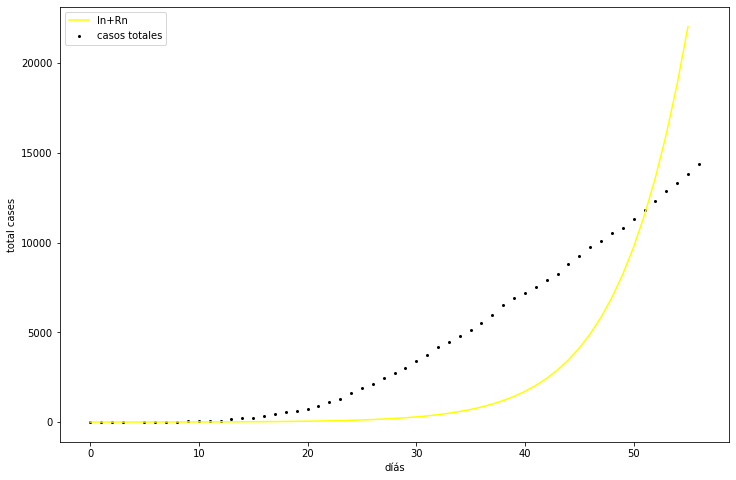

In [63]:
m = 56

plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("díás")
plt.ylabel("total cases")

plt.scatter(info["day"][:m], info["total_cases"][:m], color ="black", alpha=1,s=4)

plt.plot(info_56["day"], info_56["wn"]+info_56["vn"], color ="yellow", alpha=1)



plt.legend(['In+Rn',"casos totales"])

plt.show()

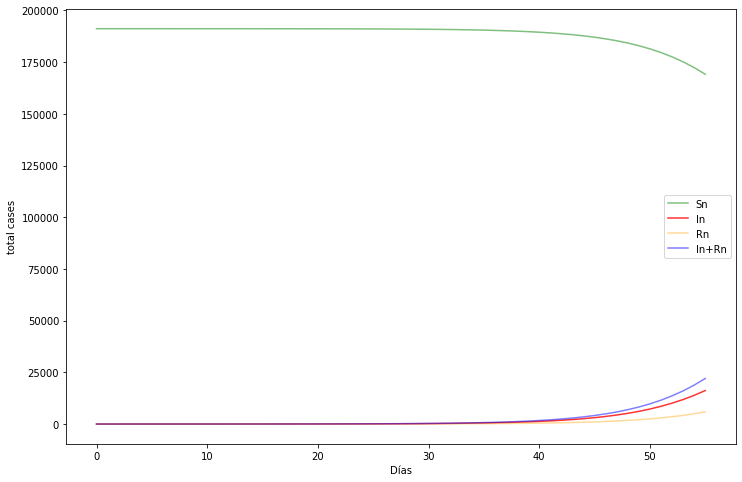

In [64]:
plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("Días")
plt.ylabel("total cases")


plt.plot(info_56["day"], info_56["un"], color ="g", alpha=0.5)
plt.plot(info_56["day"], info_56["vn"], color ="r", alpha=0.8)
plt.plot(info_56["day"], info_56["wn"], color ="#FFA500", alpha=0.4)

plt.plot(info_56["day"], info_56["wn"]+info_56["vn"], color ="b", alpha=0.5)


plt.legend(["Sn","In","Rn",'In+Rn'])

plt.show()

In [65]:
info_56["-delta Sn"] = info_56["un"].copy()
info_56["-delta Sn"][0] = 0

for i in range(1, len(info_56)):
    info_56["-delta Sn"][i] = -(info_56["un"][i] - info_56["un"][i-1])

/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


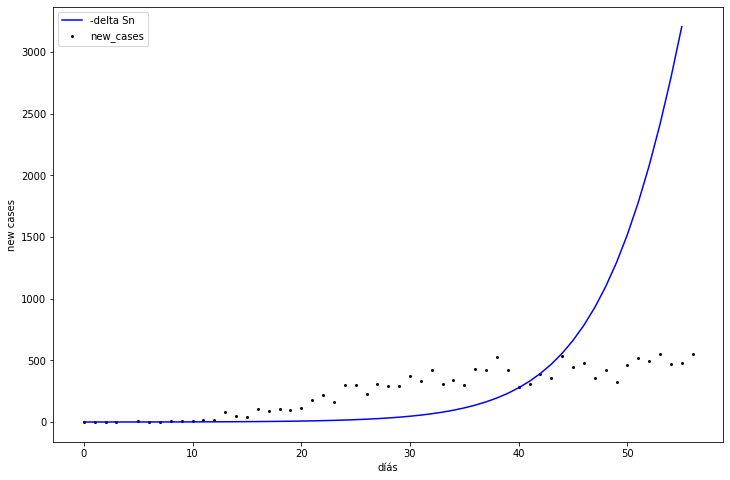

In [66]:
m = 56

plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("díás")
plt.ylabel("new cases")

plt.scatter(info["day"][:m], info["new_cases"][:m], color ="black", alpha=1,s=4)

plt.plot(info_56["day"], info_56["-delta Sn"], color ="blue", alpha=1)

plt.legend(['-delta Sn',"new_cases"])

plt.show()

In [67]:
h = 1
n = 19116209 * 0.01
m = 365
b = 0.24
a = 0.06

info_365 = discretizacion_RK_2(b, a, n, h, m)
info_365.head()

,day,un,vn,wn
0,0,191161.090000,1.000000,0.000000
1,1,191160.828402,1.196198,0.065400
2,2,191160.515479,1.430890,0.143631
3,3,191160.141162,1.711627,0.237211
4,4,191159.693406,2.047443,0.349152


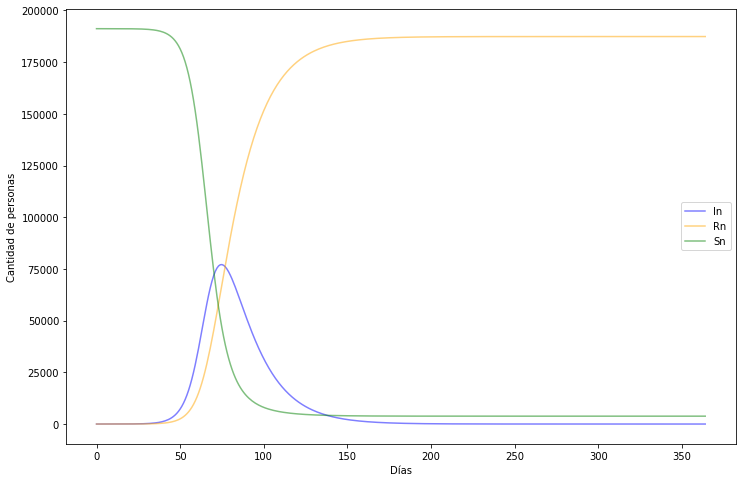

In [68]:
# Busco los datos calculados


plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("Días")
plt.ylabel("Cantidad de personas")


plt.plot(info_365["day"], info_365["vn"], color ="b", alpha=0.5)
plt.plot(info_365["day"], info_365["wn"], color ="#FFA500", alpha=0.5)
plt.plot(info_365["day"], info_365["un"], color ="g", alpha=0.5)

plt.legend(["In", "Rn", "Sn"])


plt.show()

In [69]:
# Calculo amplitud del pico

info_365["vn"].max()

77096.497004024146435

In [70]:
# Calculo dia del pico
info_365["vn"].idxmax()

75

### A5) Proceso de validación

In [71]:
h = 1
n = 19116209 * 0.01
m = 120
b = 0.24
a = 0.06


info_120 = discretizacion_RK_2(b, a, n, h, m)
info_120.head()

,day,un,vn,wn
0,0,191161.090000,1.000000,0.000000
1,1,191160.828402,1.196198,0.065400
2,2,191160.515479,1.430890,0.143631
3,3,191160.141162,1.711627,0.237211
4,4,191159.693406,2.047443,0.349152


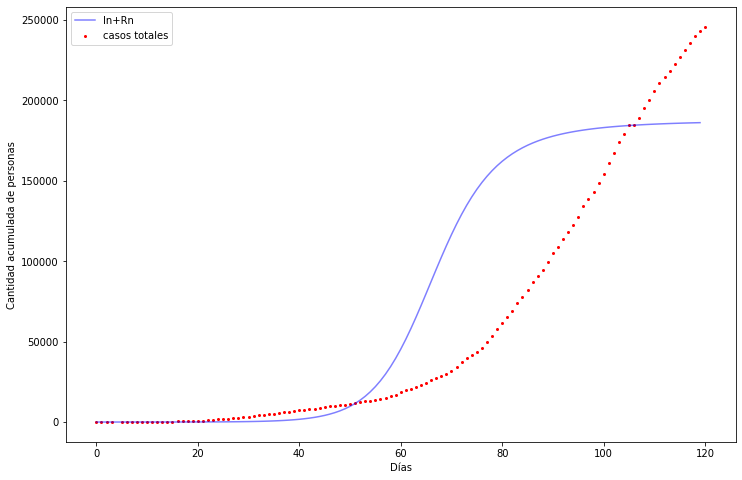

In [72]:
plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("Días")
plt.ylabel("Cantidad acumulada de personas")

plt.scatter(info["day"],info["total_cases"], color ="r", alpha=1,s=4)

plt.plot(info_120["day"], info_120["vn"]+info_120["wn"], color ="b", alpha=0.5)

plt.legend(["In+Rn","casos totales"])


plt.show()

### A6) Recalibración con  𝛽 y 𝛾 calibrados

In [73]:
m = 120
sigma =  np.arange(0,10,0.5)
alfa = [0.09,0.08,0.07,0.06]
paso =[0.01,0.001,0.0001,0.00001,1,0.5]
n = 19116209 * 0.01

calibracion_GridSearch(total_cases, n, sigma, alfa, paso, m)

    alfa     beta    sigma     paso	 error relativo %

    0.09      0.0      0.0     0.01	        100.0
    0.08      0.0      0.0     0.01	        100.0
    0.07      0.0      0.0     0.01	        100.0
    0.06      0.0      0.0     0.01	        100.0
    0.09      0.0      0.0    0.001	        100.0
    0.08      0.0      0.0    0.001	        100.0
    0.07      0.0      0.0    0.001	        100.0
    0.06      0.0      0.0    0.001	        100.0
    0.09      0.0      0.0   0.0001	        100.0
    0.08      0.0      0.0   0.0001	        100.0
    0.07      0.0      0.0   0.0001	        100.0
    0.06      0.0      0.0   0.0001	        100.0
    0.09      0.0      0.0    1e-05	        100.0
    0.08      0.0      0.0    1e-05	        100.0
    0.07      0.0      0.0    1e-05	        100.0
    0.06      0.0      0.0    1e-05	        100.0
    0.09      0.0      0.0        1	        100.0
    0.08      0.0      0.0        1	        100.0
    0.07      0.0      0.0        1	        1

    0.06     0.18      3.0        1	        42.52
    0.09     0.27      3.0      0.5	        89.24
    0.08     0.24      3.0      0.5	        95.86
    0.07     0.21      3.0      0.5	        98.54
    0.06     0.18      3.0      0.5	         99.5
    0.09     0.32      3.5     0.01	        100.0
    0.08     0.28      3.5     0.01	        100.0
    0.07     0.25      3.5     0.01	        100.0
    0.06     0.21      3.5     0.01	        100.0
    0.09     0.32      3.5    0.001	        100.0
    0.08     0.28      3.5    0.001	        100.0
    0.07     0.25      3.5    0.001	        100.0
    0.06     0.21      3.5    0.001	        100.0
    0.09     0.32      3.5   0.0001	        100.0
    0.08     0.28      3.5   0.0001	        100.0
    0.07     0.25      3.5   0.0001	        100.0
    0.06     0.21      3.5   0.0001	        100.0
    0.09     0.32      3.5    1e-05	        100.0
    0.08     0.28      3.5    1e-05	        100.0
    0.07     0.25      3.5    1e-05	        100.0


    0.09     0.58      6.5        1	        121.9
    0.08     0.52      6.5        1	       117.62
    0.07     0.46      6.5        1	       111.93
    0.06     0.39      6.5        1	        104.0
    0.09     0.58      6.5      0.5	        83.65
    0.08     0.52      6.5      0.5	        72.31
    0.07     0.46      6.5      0.5	        56.53
    0.06     0.39      6.5      0.5	        34.15
    0.09     0.63      7.0     0.01	        100.0
    0.08     0.56      7.0     0.01	        100.0
    0.07     0.49      7.0     0.01	        100.0
    0.06     0.42      7.0     0.01	        100.0
    0.09     0.63      7.0    0.001	        100.0
    0.08     0.56      7.0    0.001	        100.0
    0.07     0.49      7.0    0.001	        100.0
    0.06     0.42      7.0    0.001	        100.0
    0.09     0.63      7.0   0.0001	        100.0
    0.08     0.56      7.0   0.0001	        100.0
    0.07     0.49      7.0   0.0001	        100.0
    0.06     0.42      7.0   0.0001	        100.0


([0.07, 0.35000000000000003, 0.5], 17.612719850612635)

**Finalemente**

* Beta = 0.35
* Alfa = 0.07
* h = 0.5
* n = N . 0.01
* error relativo porcentual =  17.612719850612635

In [74]:
h = 0.5
n = 19116209 * 0.01
m = 120
b = 0.35
a = 0.07

info_121 = discretizacion_RK_2(b, a, n, h, m)

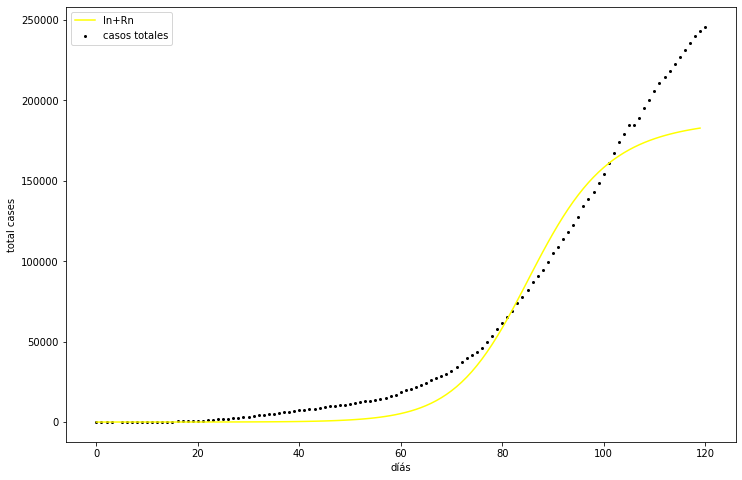

In [75]:
m = 120

plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("díás")
plt.ylabel("total cases")

plt.scatter(info["day"][:m], info["total_cases"][:m], color ="black", alpha=1,s=4)

plt.plot(info_121["day"], info_121["wn"]+info_121["vn"], color ="yellow", alpha=1)

plt.legend(['In+Rn',"casos totales"])

plt.show()

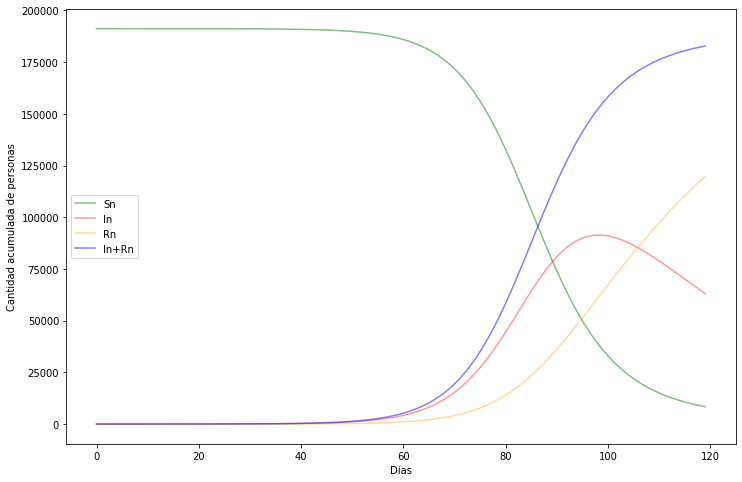

In [76]:
plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("Días")
plt.ylabel("Cantidad acumulada de personas")


plt.plot(info_121["day"], info_121["un"], color ="g", alpha=0.5)
plt.plot(info_121["day"], info_121["vn"], color ="r", alpha=0.4)
plt.plot(info_121["day"], info_121["wn"], color ="#FFA500", alpha=0.4)

plt.plot(info_121["day"], info_121["wn"]+info_121["vn"], color ="b", alpha=0.5)


plt.legend(["Sn","In","Rn",'In+Rn'])

plt.show()

In [77]:
info_121["un"]
info_121["-delta Sn"] = info_121["un"].copy()
info_121["-delta Sn"][0] = 0

for i in range(1, len(info_121)):
    info_121["-delta Sn"][i] = -(info_121["un"][i] - info_121["un"][i-1])

/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


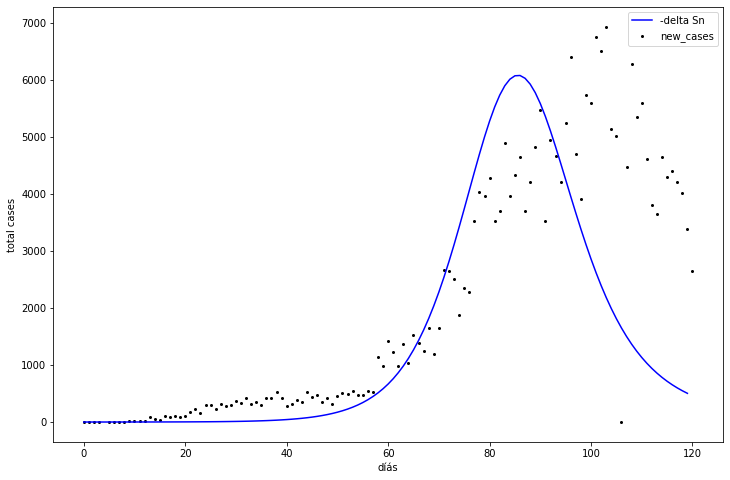

In [78]:
m = 120

plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("díás")
plt.ylabel("total cases")

plt.scatter(info["day"][:m], info["new_cases"][:m], color ="black", alpha=1,s=4)

plt.plot(info_121["day"], info_121["-delta Sn"], color ="blue", alpha=1)

plt.legend(['-delta Sn',"new_cases"])

plt.show()

### A7) N(t)

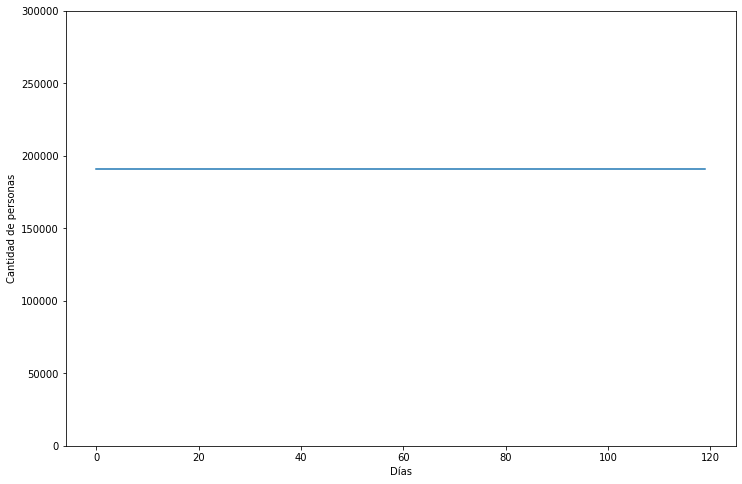

In [79]:
m = 120

info_121["N"] = info_121["un"] + info_121["vn"] + info_121["wn"] 

plt.subplots(1, 1, figsize=(12, 8))
plt.ylim((0, 3*10**5))
plt.xlabel("Días")
plt.ylabel("Cantidad de personas")

plt.plot(info_121["day"], info_121["N"])

plt.show()

### A.8)

In [80]:
N = 19116209* 0.01
BETA = 0.35
ALFA = 0.07
PASO = 0.5
SIGMA = BETA/ALFA
s_0 = (N-1)/N
i_0 = 1/N

In [81]:
# i max ecuación

i_0 + s_0 - 1/SIGMA- 1/SIGMA* sp.log(SIGMA*s_0)

0.478113463748462

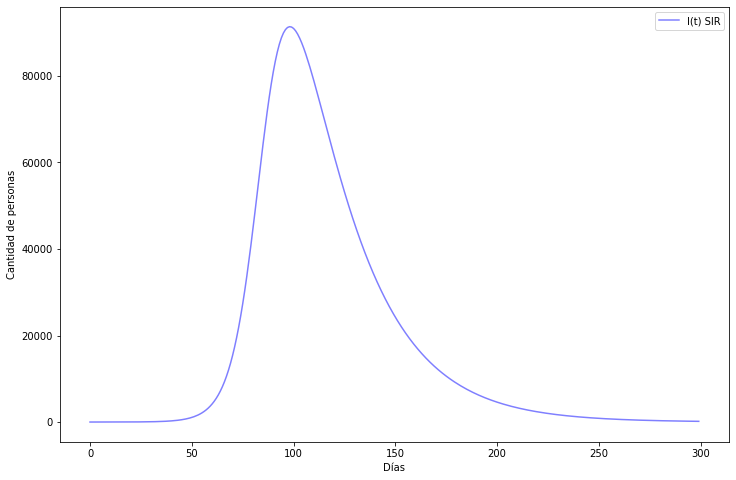

In [82]:
# Busco los datos calculados

m = 300

SIR = discretizacion_RK_2(BETA,ALFA,N,PASO, m)

plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("Días")
plt.ylabel("Cantidad de personas")


plt.plot(SIR["day"], SIR["vn"], color ="b", alpha=0.5)

plt.legend(["I(t) SIR"])


plt.show()

In [83]:
# i max numérico

SIR["vn"].max()/N

0.47804500786796539955

### A9) Cálculo de s infinito

In [84]:
def cumple_teorema_del_bolzano(f,intervalo):
    a = np.float64(intervalo[0])
    b = np.float64(intervalo[1])
    return(f(a)*f(b)<0)

In [85]:
def biseccion(f,intervalo,error_absoluto):
        
    i = 0
    
    a = np.float64(intervalo[0])
    b = np.float64(intervalo[1])
    
    errores = [np.float64((b-a)/2)]
    
    if(not cumple_teorema_del_bolzano(f,intervalo)):
        print("No cumple teorema del Bolzano")
        return
    
    print("{: >3} {: >20} {: >20} {: >20} {: >20}\n".format("i","m","a","b", "error"))

    while(errores[-1] >= np.float64(error_absoluto)):

        m = (a+b)/2

        print("{: >3} {: >20} {: >20} {: >20} {: >20}".format(i,m,a,b,errores[-1]))
        
        if(f(m)==0): return m
        
        if(f(m)*f(a)<0 ):
            b = m
        else:
            a = m
        
        i+=1
        errores.append((b-a)/2)
    
    print("{: >3} {: >20} {: >20} {: >20} {: >20}".format(i,(a+b)/2,a,b,errores[-1]))
    
    print("\n\nRaiz: ", m)
    
    return errores

In [86]:
N = 19116209* 0.01
BETA = 0.35
ALFA = 0.07
PASO = 0.5
SIGMA = BETA/ALFA
s_0 = (N-1)/N
i_0 = 1/N

f = lambda x: i_0 + s_0 - x + (1/SIGMA)* sp.log(x/s_0)

In [87]:
errores =biseccion(f,[0.000000000000001, 1/SIGMA],0.0000001)

  i                    m                    a                    b                error

  0  0.10000000000000052                1e-15  0.20000000000000004  0.09999999999999952
  1  0.05000000000000076                1e-15  0.10000000000000052  0.04999999999999976
  2  0.02500000000000088                1e-15  0.05000000000000076  0.02499999999999988
  3  0.01250000000000094                1e-15  0.02500000000000088  0.01249999999999994
  4 0.006250000000000969                1e-15  0.01250000000000094  0.00624999999999997
  5 0.009375000000000954 0.006250000000000969  0.01250000000000094 0.003124999999999985
  6 0.007812500000000961 0.006250000000000969 0.009375000000000954 0.0015624999999999923
  7 0.0070312500000009655 0.006250000000000969 0.007812500000000961 0.0007812499999999959
  8 0.006640625000000967 0.006250000000000969 0.0070312500000009655 0.0003906249999999982
  9 0.006835937500000966 0.006640625000000967 0.0070312500000009655 0.0001953124999999993
 10 0.006933593750000966

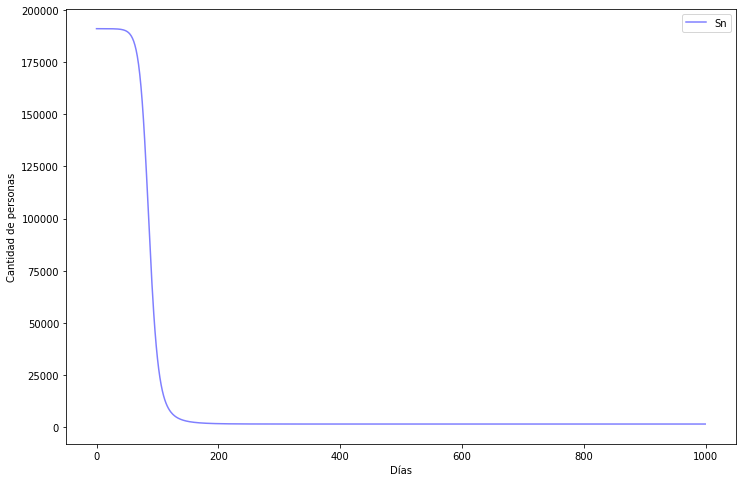

In [88]:
# Busco los datos calculados

h = 0.5
n = 19116209 * 0.01
m = 1000
b = 0.35
a = 0.07

SIR = discretizacion_RK_2(b, a, n, h, m)

plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("Días")
plt.ylabel("Cantidad de personas")


plt.plot(SIR["day"], SIR["un"], color ="b", alpha=0.5)

plt.legend(["Sn"])


plt.show()

In [89]:
# i max numérico
list(SIR["un"])[-1]/n

0.0069987957610074921383

### A4) Validación de aproximación

In [90]:
s_0 = (n-1)/n
s_inf =  0.0069772720336923715

sp.log(s_0/s_inf) / (s_0-s_inf)

5.00000458151499

In [91]:
SIGMA

4.999999999999999

## METODO B

In [92]:
def error_relativo(actual, anterior):
    return abs(actual-anterior)/actual

In [93]:
def metodo_punto_fijo(g, p, e_r= 0.001):

    anterior = p
    actual = g(p)
        
    while(error_relativo(actual, anterior)>=e_r):
        anterior = actual
        actual = g(anterior)
        
    return actual

In [94]:
def CN_get_vn_sig(un, vn, BETA,ALFA,N,h):
    
    BN = BETA/N
    hmed= h/2
    
    un_sig = lambda x: (un-hmed*BN*vn*un) / (1+hmed*BN*x)

    
    g = lambda x: vn + hmed * (BN*(x*un_sig(x)+vn*un) - ALFA*(x+vn))
            
    vn_sig = metodo_punto_fijo(g, vn)
    
    return vn_sig

In [95]:
def CN_get_un_sig(un,vn,vn_sig,BETA,ALFA,N,h):
    
    BN = BETA/N
    hmed= h/2
    
    g = lambda x: un - hmed*BN*(vn_sig*x+vn*un)
        
    un_sig = metodo_punto_fijo(g, un)
    
    return un_sig

In [96]:
def CN_get_wn_sig(wn,vn,vn_sig,BETA,ALFA,N,h):
    wn_sig = wn + (h/2)*ALFA*(vn_sig+vn)
    return wn_sig

In [97]:
def get_info_B(BETA,ALFA,N,h):
    
    info_B = inicializacion_df_SIR(121, N)
    
    for i in range(1, len(info_B)):

        un = info_B.loc[i-1, 'un']
        vn = info_B.loc[i-1, 'vn']
        wn = info_B.loc[i-1, 'wn']
        
        vn_sig = CN_get_vn_sig(un,vn,BETA,ALFA,N,h)
        info_B.loc[i, 'vn'] = vn_sig

        info_B.loc[i, 'un'] =   CN_get_un_sig(un,vn,vn_sig,BETA,ALFA,N,h)
        
        info_B.loc[i, 'wn'] = CN_get_wn_sig(wn,vn,vn_sig,BETA,ALFA,N,h)
    
    return info_B

In [98]:
N = 19116209.0 * 0.01
BETA = 0.35
ALFA = 0.07
h = 0.5
m = 121
info_B = get_info_B(BETA,ALFA,N,h)

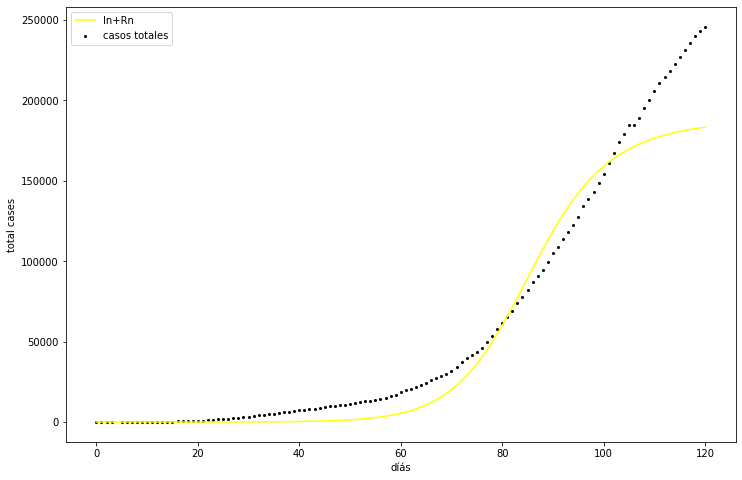

In [99]:
m = 120

plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("díás")
plt.ylabel("total cases")

plt.scatter(info["day"][:m], info["total_cases"][:m], color ="black", alpha=1,s=4)

plt.plot(info_B["day"], info_B["wn"]+info_B["vn"], color ="yellow", alpha=1)

plt.legend(['In+Rn',"casos totales"])

plt.show()

In [100]:
error_relativo_series(total_cases, info_B["vn"]+info_B["wn"], m)

17.487628509225253

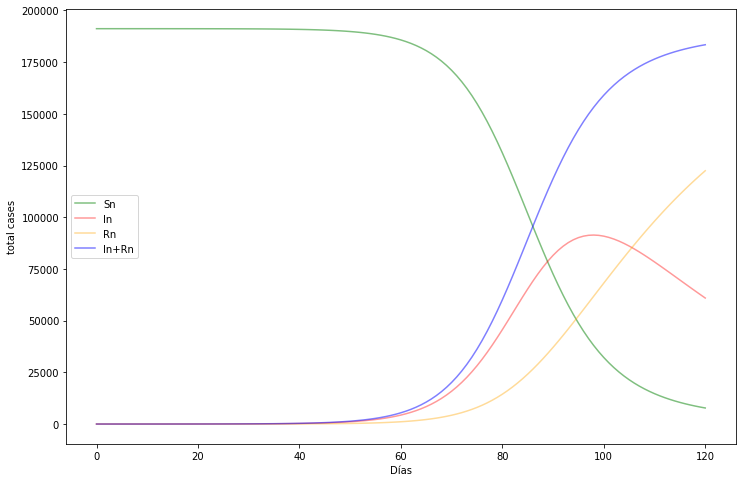

In [101]:
plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("Días")
plt.ylabel("total cases")


plt.plot(info_B["day"], info_B["un"], color ="g", alpha=0.5)
plt.plot(info_B["day"], info_B["vn"], color ="r", alpha=0.4)
plt.plot(info_B["day"], info_B["wn"], color ="#FFA500", alpha=0.4)

plt.plot(info_B["day"], info_B["wn"]+info_B["vn"], color ="b", alpha=0.5)


plt.legend(["Sn","In","Rn",'In+Rn'])

plt.show()

In [102]:
info_B["un"]
info_B["-delta Sn"] = info_B["un"].copy()
info_B["-delta Sn"][0] = 0

for i in range(1, len(info_B)):
    info_B["-delta Sn"][i] = -(info_B["un"][i] - info_B["un"][i-1])

/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


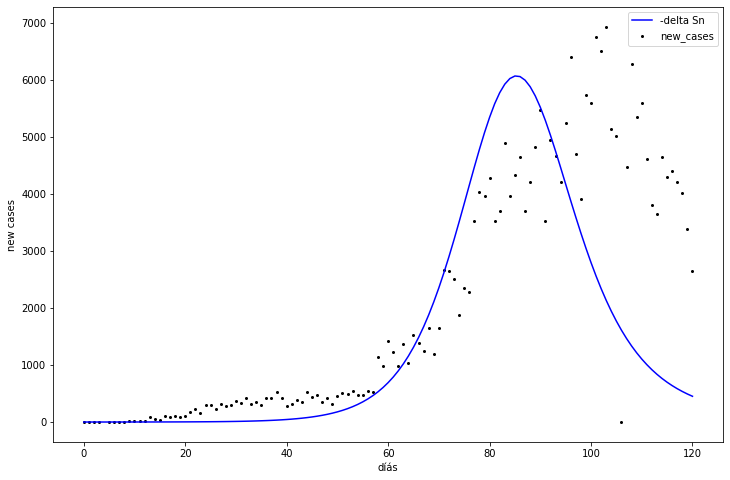

In [103]:
m = 120

plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("díás")
plt.ylabel("new cases")

plt.scatter(info["day"][:m], info["new_cases"][:m], color ="black", alpha=1,s=4)

plt.plot(info_B["day"], info_B["-delta Sn"], color ="blue", alpha=1)

plt.legend(['-delta Sn',"new_cases"])

plt.show()

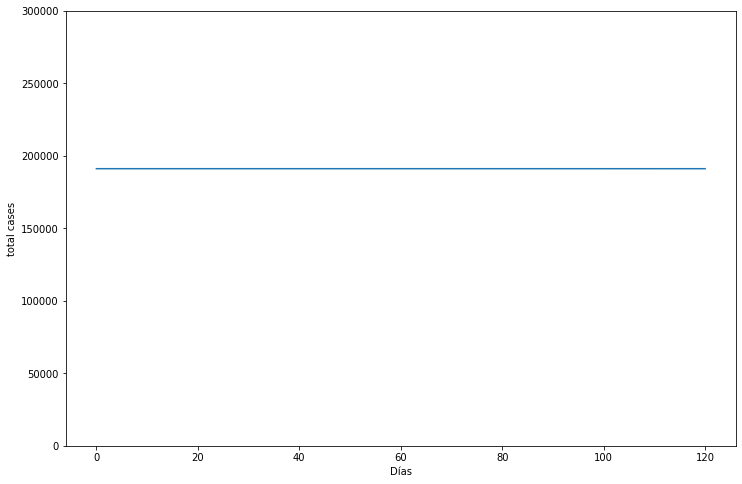

In [104]:
m = 120

info_B["N"] = info_B["un"] + info_B["vn"] + info_B["wn"] 

plt.subplots(1, 1, figsize=(12, 8))
plt.ylim((0, 3*10**5))
plt.xlabel("Días")
plt.ylabel("total cases")

plt.plot(info_B["day"], info_B["N"])

plt.show()

# COMPARACION METODOS

## Graficos

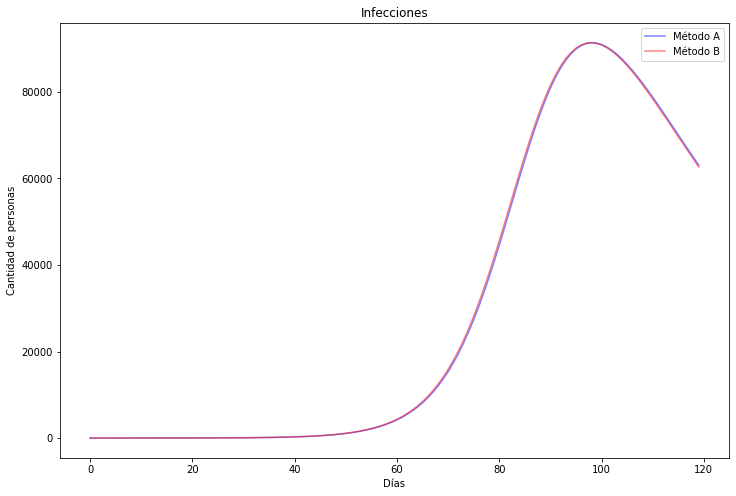

In [105]:
# Busco los datos calculados

m = 120

plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("Días")
plt.ylabel("Cantidad de personas")
plt.title("Infecciones")


plt.plot(info_121["day"][:m], info_121["vn"][:m], color ="b", alpha=0.5)
plt.plot(info_B["day"][:m], info_B["vn"][:m], color ="r", alpha=0.5)

plt.legend(["Método A", "Método B"])


plt.show()

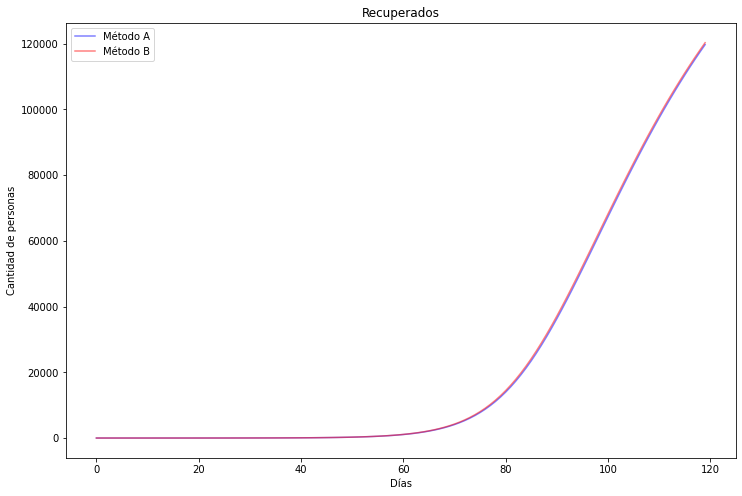

In [106]:
# Busco los datos calculados

m = 120

plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("Días")
plt.ylabel("Cantidad de personas")
plt.title("Recuperados")


plt.plot(info_121["day"], info_121["wn"], color ="b", alpha=0.5)
plt.plot(info_B["day"][:m], info_B["wn"][:m], color ="r", alpha=0.5)

plt.legend(["Método A", "Método B"])


plt.show()

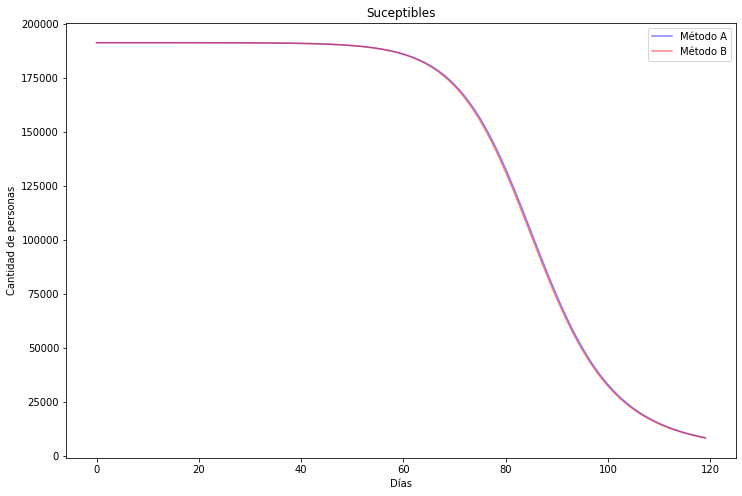

In [107]:
# Busco los datos calculados

m = 120

plt.subplots(1, 1, figsize=(12, 8))

plt.xlabel("Días")
plt.ylabel("Cantidad de personas")
plt.title("Suceptibles")


plt.plot(info_121["day"][:m], info_121["un"][:m], color ="b", alpha=0.5)
plt.plot(info_B["day"][:m], info_B["un"][:m], color ="r", alpha=0.5)

plt.legend(["Método A", "Método B"])


plt.show()

## Estabilidad

In [108]:
N = 19116209* 0.01
BETA = 0.35
ALFA = 0.07
PASO = 0.5
SIGMA = BETA/ALFA
m = 120

### Método A

In [109]:
def plot_total_cases_A(b,a,n,h,m):

    info_121 = discretizacion_RK_2(b, a, n, h, m)


    plt.subplots(1, 1, figsize=(4, 4))

    plt.xlabel("díás")
    plt.ylabel("total cases")

    plt.scatter(info["day"][:m], info["total_cases"][:m], color ="black", alpha=1,s=4)

    plt.plot(info_121["day"], info_121["wn"]+info_121["vn"], color ="yellow", alpha=1)

    plt.legend(['In+Rn',"casos totales"])
    plt.title("paso de "+str(h))

    plt.show()

0.5


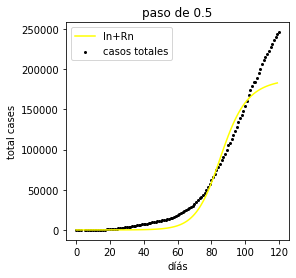





1


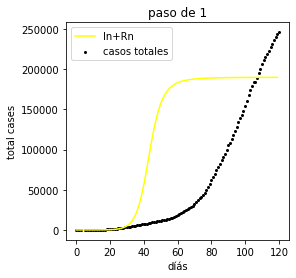





5


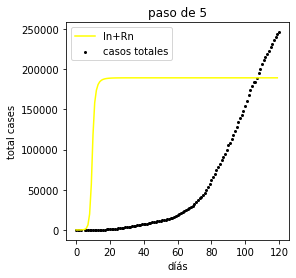





10


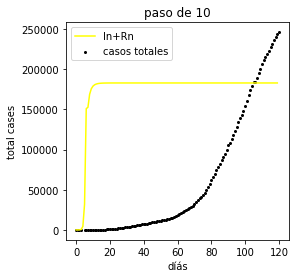





20


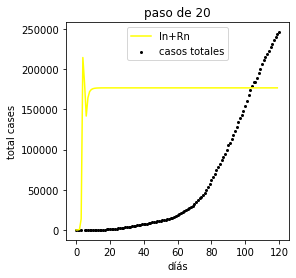





21


/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in longdouble_scalars
  
/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in longdouble_scalars
/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longdouble_scalars
  import sys


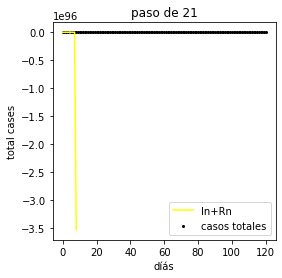





22


/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in longdouble_scalars
  
/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in longdouble_scalars
/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longdouble_scalars
  import sys


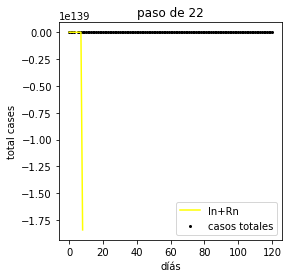

In [110]:
for h in [0.5,1,5,10,20,21,22]:
    print(h)
    plot_total_cases_A(BETA,ALFA,N,h,m)
    print("\n\n\n")

### Método B

In [111]:
N = 19116209.0 * 0.01
BETA = 0.35
ALFA = 0.07
h = 0.5
m = 120

info_B = get_info_B(BETA,ALFA,N,h)

In [112]:
def plot_total_cases_B(b,a,n,h,m):

    info_121 = get_info_B(b,a,n,h)

    plt.subplots(1, 1, figsize=(4, 4))

    plt.xlabel("díás")
    plt.ylabel("total cases")

    plt.scatter(info["day"][:m], info["total_cases"][:m], color ="black", alpha=1,s=4)

    plt.plot(info_121["day"], info_121["wn"]+info_121["vn"], color ="yellow", alpha=1)

    plt.legend(['In+Rn',"casos totales"])
    plt.title("paso de "+str(h))

    plt.show()

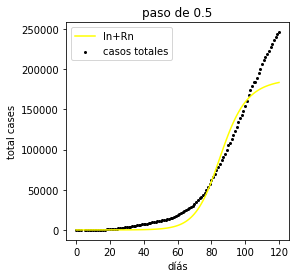

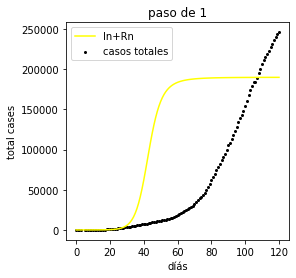

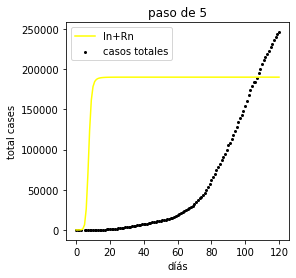

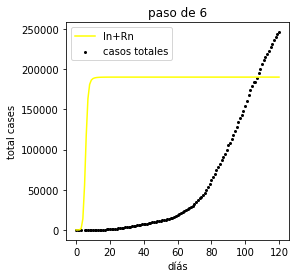

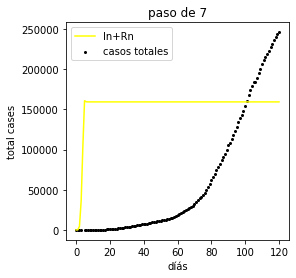

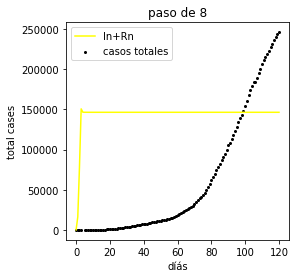

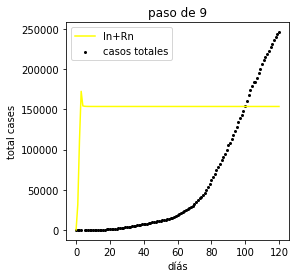

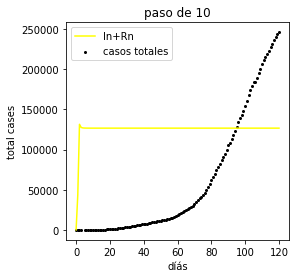

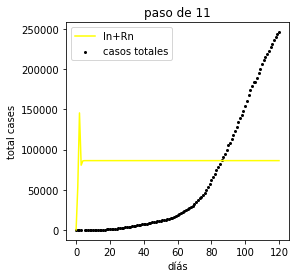

/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in longdouble_scalars
  
/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in longdouble_scalars
  
/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longdouble_scalars
  if __name__ == '__main__':


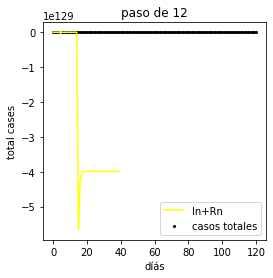

/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in longdouble_scalars
  
/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in longdouble_scalars
  if __name__ == '__main__':
/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longdouble_scalars
  if __name__ == '__main__':


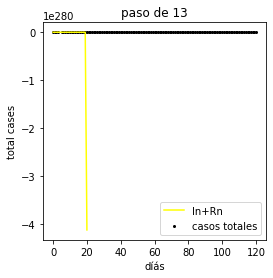

In [113]:
for h in [0.5,1,5,6,7,8,9,10,11,12,13]:
    plot_total_cases_B(BETA,ALFA,N,h,m)

## Orden de convergencia

### Método A

In [114]:
N = 19116209* 0.01
BETA = 0.35
ALFA = 0.07
PASO = 0.5
SIGMA = BETA/ALFA
m = 120

In [115]:
SIR = discretizacion_RK_2(BETA, ALFA, N, PASO, m)

In [116]:
dia = 2
SIR = discretizacion_RK_2(BETA, ALFA, N, PASO, m)
valor_calculado_fijo = SIR["vn"][dia]+SIR["wn"][dia]
errores = []

pasos = [0.6,0.7,0.8,0.9,1,1.1,\
         1.2,1.3,1.4,1.5,1.6,2,5,7,8,9,10,11,12]

for h in pasos:
    SIR = discretizacion_RK_2(BETA, ALFA, N, h, m)
    valor_calculado = SIR["vn"][dia]+SIR["wn"][dia]
    error = abs(valor_calculado_fijo-valor_calculado)
    errores.append(error)
errores

[0.094185020317981094735,
 0.19336110858683353128,
 0.29772285564496336744,
 0.40746946120895209198,
 0.52280473381588913077,
 0.64393709076356489616,
 0.7710795580484897673,
 0.9044497703017072342,
 1.0442699707223604224,
 1.1907670110089854502,
 1.344172351288488002,
 2.0316672056907612903,
 12.6273375342352056645,
 28.122893200547471763,
 39.654202550913974196,
 54.372565479833951444,
 72.833973585349431945,
 95.640353890853298226,
 123.4395311623844669]

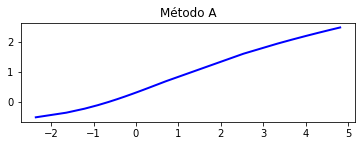

In [117]:
import pylab

log_errores =[np.log(x) for x in errores]
log_pasos = [np.log(x) for x in pasos]

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line = ax.plot(log_errores,log_pasos, color='blue', lw=2)

ax.set_title("Método A")

pylab.show()


In [118]:
table = pd.DataFrame()
table["paso"] = pasos
table["error absoluto"] = errores
table

,paso,error absoluto
0,0.6,0.094185
1,0.7,0.193361
2,0.8,0.297723
3,0.9,0.407469
4,1.0,0.522805
5,1.1,0.643937
6,1.2,0.771080
7,1.3,0.904450
8,1.4,1.044270
9,1.5,1.190767


In [119]:
def get_slope(x,y):
    
    x = np.array(x)
    y = np.array(y)
    
    X = x - x.mean()
    Y = y - y.mean()

    slope = (X.dot(Y)) / (X.dot(X))
    return slope

In [120]:
get_slope(log_pasos,log_errores)

2.1932287678707026032

### Método B

In [121]:
N = 19116209* 0.01
BETA = 0.35
ALFA = 0.07
PASO = 0.5
SIGMA = BETA/ALFA
m = 120

In [122]:
dia = 1
SIR = get_info_B(BETA, ALFA, N, PASO)
valor_calculado_fijo = SIR["vn"][dia]+SIR["wn"][dia]
errores = []

pasos = [0.6,0.7,0.8,0.9,1,1.1,\
         1.2,1.3,1.4,1.5,1.6,2,3,4,5,6]

for h in pasos:
    SIR = get_info_B(BETA,ALFA,N,h)
    valor_calculado = SIR["vn"][dia]+SIR["wn"][dia]
    error = abs(valor_calculado_fijo-valor_calculado)
    errores.append(error)
errores

[0.04112849510936391717,
 0.0834779167347989065,
 0.12715394786509940056,
 0.17221594317449949755,
 0.21872582003098432323,
 0.26674809073037291306,
 0.3166287767911380429,
 0.368018559719277583,
 0.42118081031235066246,
 0.47620363615530639744,
 0.53317997380106015633,
 0.78369064593637916536,
 1.6206360746688181415,
 2.988623435596633994,
 5.631764357826238104,
 12.862477745407162278]

In [123]:
table = pd.DataFrame()
table["paso"] = pasos
table["error absoluto"] = errores
table

,paso,error absoluto
0,0.6,0.041128
1,0.7,0.083478
2,0.8,0.127154
3,0.9,0.172216
4,1.0,0.218726
5,1.1,0.266748
6,1.2,0.316629
7,1.3,0.368019
8,1.4,0.421181
9,1.5,0.476204


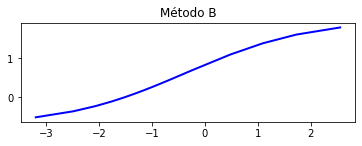

In [124]:
import pylab

log_errores =[np.log(x) for x in errores]
log_pasos = [np.log(x) for x in pasos]

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line = ax.plot(log_errores,log_pasos, color='blue', lw=2)

ax.set_title("Método B")

pylab.show()


In [125]:
def get_slope(x,y):
    
    x = np.array(x)
    y = np.array(y)
    
    X = x - x.mean()
    Y = y - y.mean()

    slope = (X.dot(Y)) / (X.dot(X))
    return slope

In [126]:
get_slope(log_pasos,log_errores)

2.1774239825628787471